In [5]:
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.4/648.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.3/249.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 96.2 MB/s eta 0:00

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [8]:
os.environ["OPENAI_API_KEY"] = "your-api-key"

In [9]:
# Simple method - Split by pages
loader = PyPDFLoader("./dataset.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='Category - Mental Health and Well-Being  \n  \nQuestion. What kind of facilities does Lambton College in Toronto provide in terms of dealing with mental \nhealth issues?  \nAnswer: Lambton college in Toronto has an on-campus Student Welness and Accessibility Centre, which \nis dedicated to providing services related to physical and mental health, accessibility, and accomodations.\n Lambton college also provides community resources to deal with mental health issues.  \nTo know more in detail regarding the resources available, you can visit this link: https://www.lambtoncolle\nge.ca/Programs/International/Lambton_in_Toronto/Health___Wellness/  \n  \nQuestion. What to do if you face discrimination of any kind inside the Lambton college campus?  \nAnswer: Answer: If you face discrimination of any kind inside the Lambton College campus, it is important\n to take appropriate steps to address the situation. Here are some recommended actions:  \nReport the Incident: Immediately r

In [14]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("./dataset.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('dataset.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('dataset.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

In [15]:
type(chunks[0])

langchain.schema.Document

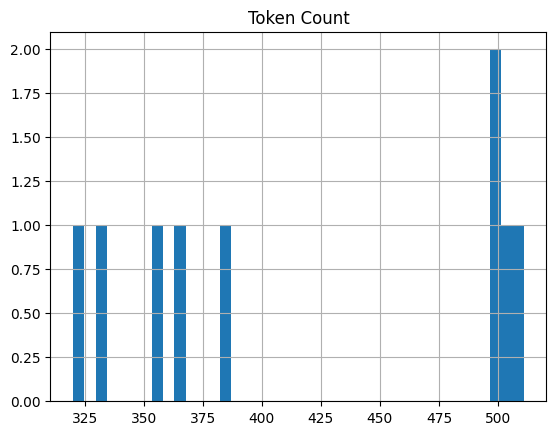

In [19]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

In [23]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

In [24]:
# Check similarity search is working
query = "Who created transformers?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='process to get a driver’s license in Canada depends on the province or territory where you live and on you\nr driving background. It may include:  \na written exam on the rules of the road (you can get a study guide to help with this)  \none or two driving tests  \n  \nQuestion. Who are top-tier mobile service providers?  \nAnswer: These three companies, Bell Mobility, Rogers Wireless, and Telus Mobility, are often referred to \nas the "Big Three" in the Canadian telecommunications industry due to their size, network coverage, and \nmarket share.  \nThese second-tier mobile service providers often offer competitive pricing, flexible plans, and good covera\nge in their respective service areas. Fido, Chatr mobile (a subsidiary of Rogers Communications ), Koodo,\n Public (Telus), Virgin(Bell), and Freedom are the second-tier service providers.  \n  \nQuestion. How do I open a bank account in Canada?  \nAnswer: To open a bank account in Canada, you’ll need to provid

In [27]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "Which is best service provider in Canada?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' The "Big Three" in the Canadian telecommunications industry are Bell Mobility, Rogers Wireless, and Telus Mobility. These companies are often referred to as the top-tier service providers due to their size, network coverage, and market share. Other second-tier service providers include Fido, Chatr mobile (a subsidiary of Rogers Communications ), Koodo, Public (Telus), Virgin(Bell), and Freedom. These companies often offer competitive pricing, flexible plans, and good coverage in their respective service areas.'

In [28]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [29]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> How are you?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  I\'m doing well, thank you. How about you?')

HTML(value='<b>User:</b> Tell me about Lambton College')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Lambton College is a public college located in Toronto,…

HTML(value='<b>User:</b> How to set up a bank account on your mobile')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Download the corresponding bank apps which will be avai…

HTML(value='<b>User:</b> What is an I care interactive chatbot?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  An I care interactive chatbot is an AI-powered chatbot …

HTML(value='<b>User:</b> Is it hard to study in Canada')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Studying in Canada can be both challenging and rewardin…

HTML(value='<b>User:</b> Explain in detail')

HTML(value='<b><font color="blue">Chatbot:</font></b>  When studying in Canada, there are several factors to c…